In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [4]:
try:
    df = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/data_features_engineered.csv', index_col='Datetime', parse_dates=True)
    print(f" Data loaded: {len(df):,} records")
    print(f" Columns: {len(df.columns)}")
    print(f" Date range: {df.index.min()} to {df.index.max()}")
except FileNotFoundError:
    print(" Error: data_features_engineered.csv not found!")
    print("Please run Module 3 (Feature Engineering) first")
    exit()

 Data loaded: 34,421 records
 Columns: 78
 Date range: 2006-12-23 17:00:00 to 2010-11-26 21:00:00


In [5]:
target_col = 'Global_active_power'

# Selecting important features (not all 80+ to avoid noise)
# Using carefully chosen subset for LSTM
selected_features = [
    # Lag features (strongest predictors)
    f'{target_col}_lag_1h',
    f'{target_col}_lag_2h',
    f'{target_col}_lag_3h',
    f'{target_col}_lag_6h',
    f'{target_col}_lag_12h',
    f'{target_col}_lag_24h',
    f'{target_col}_lag_48h',
    f'{target_col}_lag_168h',
    # Rolling features
    f'{target_col}_rolling_mean_6h',
    f'{target_col}_rolling_mean_24h',
    f'{target_col}_rolling_mean_168h',
    f'{target_col}_rolling_std_24h',
    # Time features
    'hour', 'hour_sin', 'hour_cos',
    'dayofweek', 'is_weekend',
    'month', 'month_sin', 'month_cos',
    'season',
    # Device features
    'total_sub_metering',
    'Sub_metering_1_lag_24h',
    'Sub_metering_2_lag_24h',
    'Sub_metering_3_lag_24h',
    # Advanced features
    f'{target_col}_diff_1h',
    f'{target_col}_diff_24h',
    f'{target_col}_ema_24h',
    f'{target_col}_momentum_24h',
]

# Filter to only existing columns
selected_features = [f for f in selected_features if f in df.columns]

X = df[selected_features].values
y = df[target_col].values

print(f" Selected features: {len(selected_features)}")
print(f"   Target: {target_col}")
print(f"   Samples: {len(X):,}")

 Selected features: 29
   Target: Global_active_power
   Samples: 34,421


In [6]:
# Split data into train, val, test

total = len(X)
train_end = int(0.7 * total)
val_end = train_end + int(0.15 * total)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"   Train:      {len(X_train):,} samples (70%)")
print(f"   Validation: {len(X_val):,} samples (15%)")
print(f"   Test:       {len(X_test):,} samples (15%)")

   Train:      24,094 samples (70%)
   Validation: 5,163 samples (15%)
   Test:       5,164 samples (15%)


In [7]:
# Scaling Features (MinMax 0-1)

# Scale features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(" Features scaled (0-1) using MinMax")
print(" Target scaled (0-1) using MinMax")
print(" Fitted on training data only (no data leakage)")

 Features scaled (0-1) using MinMax
 Target scaled (0-1) using MinMax
 Fitted on training data only (no data leakage)


In [8]:
# Creating Sequences for LSTM

def create_sequences(X, y, seq_length):
    """
    LSTM needs sequential input: [batch, timesteps, features]
    This function creates sliding window sequences.
    
    Example with seq_length=24:
    Sequence 1: hours 0-23  → predict hour 24
    Sequence 2: hours 1-24  → predict hour 25
    Sequence 3: hours 2-25  → predict hour 26
    ...
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:(i + seq_length)])   # Last 24 hours
        ys.append(y[i + seq_length])        # Predict next hour
    return np.array(Xs), np.array(ys)

# Sequence length = 24 hours (1 day lookback)
SEQ_LENGTH = 24

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

print(f"   Sequence length: {SEQ_LENGTH} hours (1 day lookback)")
print(f"\n Sequence Shapes:")
print(f"   X_train: {X_train_seq.shape} → (samples, timesteps, features)")
print(f"   X_val:   {X_val_seq.shape}")
print(f"   X_test:  {X_test_seq.shape}")
print(f"   y_train: {y_train_seq.shape}")

   Sequence length: 24 hours (1 day lookback)

 Sequence Shapes:
   X_train: (24070, 24, 29) → (samples, timesteps, features)
   X_val:   (5139, 24, 29)
   X_test:  (5140, 24, 29)
   y_train: (24070,)


In [9]:
# Building LSTM Model Architecture

def build_lstm_model(n_features, seq_length, learning_rate=0.001):
    """
    LSTM Architecture:
    Input → LSTM(64) → Dropout → LSTM(32) → Dropout → Dense(16) → Dense(1)
    
    Layer explanation:
    - LSTM(64): First LSTM layer with 64 units (learns complex patterns)
    - Dropout(0.2): Prevents overfitting (randomly drops 20% connections)
    - LSTM(32): Second LSTM layer (refines patterns, return_sequences=False)
    - Dropout(0.2): More regularization
    - Dense(16): Fully connected layer (combines learned features)
    - Dense(1): Output layer (single prediction value)
    """
    model = Sequential([
        Input(shape=(seq_length, n_features)),
        LSTM(64, return_sequences=True),   # First LSTM - returns full sequence
        Dropout(0.2),
        LSTM(32, return_sequences=False),  # Second LSTM - returns last output only
        Dropout(0.2),
        Dense(16, activation='relu'),      # Hidden dense layer
        Dense(1)                           # Output: single prediction
    ])
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',                        # Mean Squared Error loss
        metrics=['mae']                    # Track MAE during training
    )
    
    return model

# Build the model
n_features = X_train_seq.shape[2]
model = build_lstm_model(n_features, SEQ_LENGTH)

print("\n Model Architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\n Total parameters: {total_params:,}")


 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,025 (144.63 KB)

 Trainable params: 37,025 (144.63 KB)

 Non-trainable params: 0 (0.00 B)


 Total parameters: 37,025


In [10]:
# Setting Up Training Configuration

# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

print(f"\n Hyperparameters:")
print(f"   • Batch Size:     {BATCH_SIZE}")
print(f"   • Max Epochs:     {EPOCHS}")
print(f"   • Learning Rate:  {LEARNING_RATE}")
print(f"   • Sequence Length:{SEQ_LENGTH}")

# Callbacks
callbacks = [
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Multiply LR by 0.5
        patience=5,           # Wait 5 epochs
        min_lr=0.0001,        # Minimum LR
        verbose=1
    )
]

print(f"\n Callbacks:")
print(f"   • EarlyStopping: patience=10 (stops if no improvement)")
print(f"   • ReduceLROnPlateau: patience=5, factor=0.5 (reduces LR on plateau)")



 Hyperparameters:
   • Batch Size:     32
   • Max Epochs:     100
   • Learning Rate:  0.001
   • Sequence Length:24

 Callbacks:
   • EarlyStopping: patience=10 (stops if no improvement)
   • ReduceLROnPlateau: patience=5, factor=0.5 (reduces LR on plateau)


In [11]:
# Training LSTM Model

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=callbacks,
    verbose=1
)

actual_epochs = len(history.history['loss'])
print(f"\n Training completed!")
print(f"   • Epochs trained: {actual_epochs} (out of {EPOCHS} max)")
print(f"   • Final training loss: {history.history['loss'][-1]:.6f}")
print(f"   • Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"   • Best validation loss: {min(history.history['val_loss']):.6f}")

Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0243 - mae: 0.1174 - val_loss: 0.0184 - val_mae: 0.0993 - learning_rate: 0.0010
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0174 - mae: 0.0960 - val_loss: 0.0147 - val_mae: 0.0889 - learning_rate: 0.0010
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0155 - mae: 0.0887 - val_loss: 0.0132 - val_mae: 0.0854 - learning_rate: 0.0010
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0145 - mae: 0.0854 - val_loss: 0.0137 - val_mae: 0.0849 - learning_rate: 0.0010
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0139 - mae: 0.0829 - val_loss: 0.0124 - val_mae: 0.0791 - learning_rate: 0.0010
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0136 - mae: 0.0818 - val_loss: 0.0122 - val_mae: 0.0794 - learning_rate: 0.0010
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0133 - mae: 0.0807 - val_loss: 0.0122 - val_mae: 0.0800 - learnin

In [12]:
# Making Predictions

# Predict on all sets
y_train_pred_scaled = model.predict(X_train_seq, verbose=0).ravel()
y_val_pred_scaled = model.predict(X_val_seq, verbose=0).ravel()
y_test_pred_scaled = model.predict(X_test_seq, verbose=0).ravel()

# Inverse transform predictions back to original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# Also inverse transform actual values (aligned with sequences)
y_train_actual = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1)).ravel()
y_val_actual = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1)).ravel()
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

print(f" Predictions made and inverse transformed")
print(f"   • Train predictions: {len(y_train_pred):,}")
print(f"   • Val predictions:   {len(y_val_pred):,}")
print(f"   • Test predictions:  {len(y_test_pred):,}")

 Predictions made and inverse transformed
   • Train predictions: 24,070
   • Val predictions:   5,139
   • Test predictions:  5,140


In [13]:
# Evaluating LSTM Performance

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    return {'Dataset': name, 'MAE': mae, 'RMSE': rmse, 'R² Score': r2, 'MAPE (%)': mape}

train_metrics = evaluate(y_train_actual, y_train_pred, 'Training')
val_metrics = evaluate(y_val_actual, y_val_pred, 'Validation')
test_metrics = evaluate(y_test_actual, y_test_pred, 'Test')

metrics_df = pd.DataFrame([train_metrics, val_metrics, test_metrics])

print("\n LSTM MODEL PERFORMANCE:")
print(metrics_df.to_string(index=False))

# Overfitting check
gap = abs(train_metrics['R² Score'] - test_metrics['R² Score'])
print(f"\n Overfitting Check (R² gap: {gap:.4f}):")
if gap < 0.05:
    print("    Good generalization!")
elif gap < 0.10:
    print("    Slight overfitting")
else:
    print("    Significant overfitting - consider more dropout or less epochs")



 LSTM MODEL PERFORMANCE:
   Dataset      MAE     RMSE  R² Score  MAPE (%)
  Training 0.336114 0.492946  0.694401 43.292547
Validation 0.361649 0.511848  0.655180 38.382984
      Test 0.310126 0.452482  0.574709 39.141536

 Overfitting Check (R² gap: 0.1197):
    Significant overfitting - consider more dropout or less epochs


 Visualization saved as 'module5_lstm_results.png'


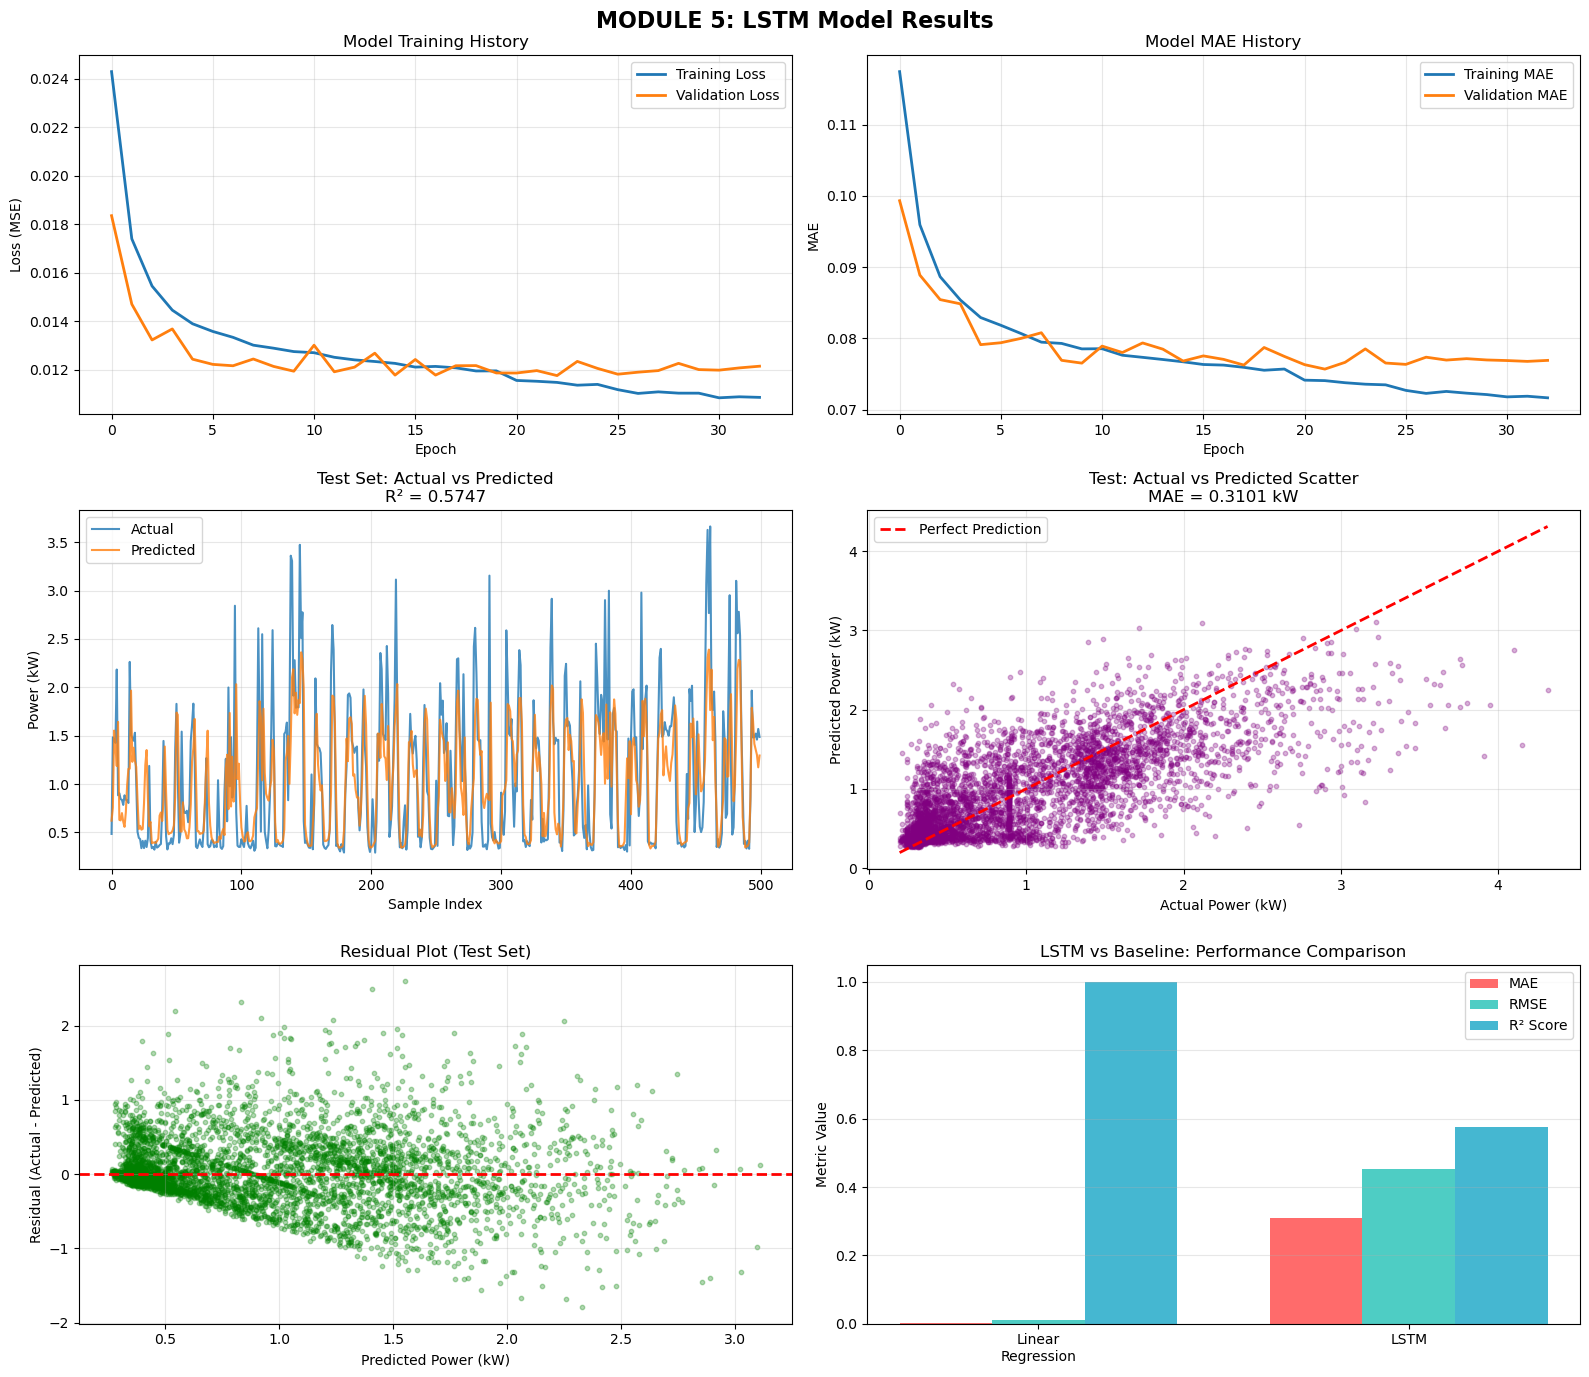

In [14]:
# Creating LSTM Visualizations

fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('MODULE 5: LSTM Model Results', fontsize=16, fontweight='bold')

# Plot 1: Training History (Loss)
ax1 = axes[0, 0]
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Training History')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Training History (MAE)
ax2 = axes[0, 1]
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_title('Model MAE History')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Actual vs Predicted (Test Set - Line)
ax3 = axes[1, 0]
sample = min(500, len(y_test_actual))
ax3.plot(range(sample), y_test_actual[:sample], label='Actual', linewidth=1.5, alpha=0.8)
ax3.plot(range(sample), y_test_pred[:sample], label='Predicted', linewidth=1.5, alpha=0.8)
ax3.set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R² Score"]:.4f}')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Power (kW)')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Scatter Plot (Test Set)
ax4 = axes[1, 1]
ax4.scatter(y_test_actual, y_test_pred, alpha=0.3, s=10, color='purple')
min_val = min(y_test_actual.min(), y_test_pred.min())
max_val = max(y_test_actual.max(), y_test_pred.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax4.set_title(f'Test: Actual vs Predicted Scatter\nMAE = {test_metrics["MAE"]:.4f} kW')
ax4.set_xlabel('Actual Power (kW)')
ax4.set_ylabel('Predicted Power (kW)')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Residual Plot
ax5 = axes[2, 0]
residuals = y_test_actual - y_test_pred
ax5.scatter(y_test_pred, residuals, alpha=0.3, s=10, color='green')
ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax5.set_title('Residual Plot (Test Set)')
ax5.set_xlabel('Predicted Power (kW)')
ax5.set_ylabel('Residual (Actual - Predicted)')
ax5.grid(alpha=0.3)

# Plot 6: Metrics Comparison (LSTM vs Baseline)
ax6 = axes[2, 1]
# Load baseline metrics if available
try:
    baseline_df = pd.read_csv('C:/Users/battu/Documents/SmartEnergyML/data/processed/baseline_model_metrics.csv')
    baseline_test = baseline_df[baseline_df['Dataset'] == 'Test'].iloc[0]
    
    models = ['Linear\nRegression', 'LSTM']
    mae_vals = [baseline_test['MAE'], test_metrics['MAE']]
    rmse_vals = [baseline_test['RMSE'], test_metrics['RMSE']]
    r2_vals = [baseline_test['R² Score'], test_metrics['R² Score']]
    
    x = np.arange(len(models))
    width = 0.25
    
    ax6.bar(x - width, mae_vals, width, label='MAE', color='#FF6B6B')
    ax6.bar(x, rmse_vals, width, label='RMSE', color='#4ECDC4')
    ax6.bar(x + width, r2_vals, width, label='R² Score', color='#45B7D1')
    
    ax6.set_title('LSTM vs Baseline: Performance Comparison')
    ax6.set_xticks(x)
    ax6.set_xticklabels(models)
    ax6.set_ylabel('Metric Value')
    ax6.legend()
    ax6.grid(axis='y', alpha=0.3)
    
except FileNotFoundError:
    ax6.text(0.5, 0.5, 'Baseline metrics not found\n(Run Module 4 first)',
            ha='center', va='center', transform=ax6.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('module5_lstm_results.png', dpi=300, bbox_inches='tight')
print(" Visualization saved as 'module5_lstm_results.png'")
plt.show()

In [15]:
# Saving LSTM Model and Results

# Save model
model.save('lstm_energy_prediction_model.h5')
print(" Saved: lstm_energy_prediction_model.h5")

# Save scalers
import joblib
joblib.dump(scaler_X, 'lstm_feature_scaler.pkl')
joblib.dump(scaler_y, 'lstm_target_scaler.pkl')
print(" Saved: lstm_feature_scaler.pkl")
print(" Saved: lstm_target_scaler.pkl")

# Save metrics
metrics_df.to_csv('lstm_model_metrics.csv', index=False)
print(" Saved: lstm_model_metrics.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': y_test_pred,
    'Error': y_test_actual - y_test_pred,
    'Abs_Error': np.abs(y_test_actual - y_test_pred)
})
predictions_df.to_csv('lstm_model_predictions.csv', index=False)
print(" Saved: lstm_model_predictions.csv")

# Save selected features list
pd.Series(selected_features).to_csv('lstm_selected_features.txt', index=False, header=False)
print(" Saved: lstm_selected_features.txt")

 Saved: lstm_energy_prediction_model.h5
 Saved: lstm_feature_scaler.pkl
 Saved: lstm_target_scaler.pkl
 Saved: lstm_model_metrics.csv
 Saved: lstm_model_predictions.csv
 Saved: lstm_selected_features.txt
